In [1]:
### packages ###
import random
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib import ticker
import modelbase
from tqdm.notebook import tqdm

from modelbase.ode import Simulator
from scipy.integrate import trapezoid
from typing import Iterable, Dict, Tuple, Optional, Any, List, Union
import itertools as it
from matplotlib import cm
from modelbase.ode import mca


In [2]:
%%capture
cd ../..

In [3]:
from models import get_model

In [4]:
%%capture
cd master_thesis/NPQ_analysis

In [5]:
y0 = {
    "PQ": 11.027139850905353,
    "PC": 1.8895071932002812,
    "Fd": 3.8690237263896705,
    "ATP": 1.620195002854852,
    "NADPH": 0.4882103700673736,
    "H": 0.0022147075094596015,
    "LHC": 0.8023074419510501,
    "Psbs": 0.9607146039898598,
    "Vx": 0.950783616933656,
    "PGA": 0.9913970817549008,
    "BPGA": 0.0005355311557548053,
    "GAP": 0.0062630116252017295,
    "DHAP": 0.13778623933075737,
    "FBP": 0.006126990841013743,
    "F6P": 0.31166103888161867,
    "G6P": 0.7168203893211117,
    "G1P": 0.041575582577936025,
    "SBP": 0.01311315151803723,
    "S7P": 0.15782894767619207,
    "E4P": 0.00732079113061801,
    "X5P": 0.022396849486562384,
    "R5P": 0.03751472214765548,
    "RUBP": 0.13153657267999222,
    "RU5P": 0.015005888732707041,
    "MDA": 5.85270097771621e-06,
    "ASC": 9.999994138785292,
    "H2O2": 3.4273920330125316e-06,
    "DHA": 8.513863740903352e-09,
    "GSH": 9.999999991725186,
    "GSSG": 4.137406632226743e-09,
    "TR_ox": 0.9,
    "E_inactive": 4.7368421052631575,
}

In [6]:
m = get_model() #get model

In [7]:
#add new parameters with values from Dave Kramer 
m.add_parameter("b6f_content", 1)
m.add_parameter("max_b6f", 500)
m.add_parameter("pKreg", 6.5)

##forward rate constant, consisiting of pH depending component that pumps protons into lumen
##protonation rate, which depends on pH and multiplied with scaling parameter
def k_b6f(pH , pKreg, b6f_content, max_b6f):
    pHmod=(1 - (1 / (10 ** (pH - pKreg) + 1)))
    b6f_deprot=pHmod*b6f_content
    return b6f_deprot * max_b6f

m.add_algebraic_module(module_name="k_b6f",
        function=k_b6f,
        compounds=["pH"],
        derived_compounds=["k_b6f"],
        parameters=["pKreg", "b6f_content", "max_b6f"],)

##because reaction is reversible forward rate constant/eq constant = reverse rate constant
#simple reaction rate, concentration substrates * forwards - concentration products - backwards
##!!!!!!!check whether it is necessary to keep PQ in fraction and not total number!!!!!!!
def vB6f(PC, PCred, PQ, PQred, k_b6f ,Keq_cytb6f):    
    k_b6f_reverse = k_b6f / Keq_cytb6f
    f_PQH2=PQred/(PQred+PQ) #want to keep the rates in terms of fraction of PQHs, not total number
    f_PQ=1-f_PQH2
    return f_PQH2*PC*k_b6f - f_PQ*PCred*k_b6f_reverse 

m.add_reaction(rate_name="vB6f",
        function=vB6f,
        stoichiometry={"PC": -2, "PQ": 1, "H": 4 / m.get_parameter("bH")},
        modifiers=["PQred", "PCred", "k_b6f", "Keq_B6f"],
        dynamic_variables=["PC","PCred", "PQ", "PQred", "k_b6f","Keq_B6f"],
        reversible=True,
    )

In [8]:
m.add_parameter("ATPturnover", 90)


def ATP_gamma(Pi,ATP,ADP,convf):
    return (ATP/convf)/((ADP/convf)*(Pi/1000))

m.add_algebraic_module_from_args(
        module_name="ATP_gamma",
        function=ATP_gamma,
        args=["Pi", "ATP", "ADP", "convf"],
        derived_compounds=["ATP_gamma"])

def deltagATPsyn(pH,gammaATP,DeltaG0_ATP,dG_pH, HPR, pHstroma, RT):
    DG = DeltaG0_ATP - dG_pH * HPR * (pHstroma - pH) + RT* np.log(gammaATP)
    return DG

m.add_algebraic_module_from_args(
    module_name="DeltaGATPsyn",
    function=deltagATPsyn,
    args=["pH","ATP_gamma","DeltaG0_ATP","dG_pH", "HPR", "pHstroma", "RT"],
    derived_compounds=["DeltaGATPsyn"])


m.remove_reaction("vATPsynthase")

def vATPsynthase2(DeltaGATPsyn, ATPturnover):
    return -DeltaGATPsyn*ATPturnover

m.add_reaction(
        rate_name="vATPsynthase",
        function=vATPsynthase2,
        stoichiometry={
            "H": -m.get_parameter("HPR") / m.get_parameter("bH"),
            "ATP": 1 * m.get_parameter("convf"),
        },
        modifiers=["DeltaGATPsyn"],
        dynamic_variables=["DeltaGATPsyn"],
        parameters=["ATPturnover"],
        reversible=True)


In [9]:
def pam_analysis(
    s: Simulator,
    t_relax: float,
    t_pulse: float,
    pfd_dark: float,
    pfd_illumination: float,
    pfd_pulse: float,
    adaption :float,
    time_adaption : float,
    integrator_kwargs: Dict[str, Any] = None,
) -> None:
    if integrator_kwargs is None:
        integrator_kwargs = {}
    s.update_parameter("pfd", adaption)
    s.simulate(time_adaption)
    print("adaption done with:",str(time_adaption)+" and "+str(adaption))
    t = list(it.accumulate(it.chain.from_iterable((t_relax, t_pulse) for i in range(32))))
    for f in range(len(t)):
        t[f]= t[f] + time_adaption
    pfds = list(
        [pfd_dark, pfd_pulse] * 2
        + [pfd_illumination, pfd_pulse] * 10
        + [pfd_dark, pfd_pulse] * 8
    )
    for t_end, pfd in tqdm(zip(t, pfds), total=len(pfds), desc="simulation"):
        s.update_parameter("pfd", pfd)
        s.simulate(t_end, **integrator_kwargs)


def get_light(s: Simulator) -> np.ndarray:
    values = [
        list(it.repeat(par["pfd"], len(t)))
        for par, t in zip(s1.simulation_parameters, s1.get_time(concatenated=False))
    ]
    return np.fromiter(it.chain(*values), dtype="float")


def get_npq(
    s: Simulator,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Calculates the non-photochemical quenching from the extracted
    important points of the PAM simulations

    Returns
    -------
    Fm: Fm (first element of list) and Fm' values
    NPQ: Calculated NPQ values
    tm: Exact time points of peaks in PAM trace
    Fo: Fo (first element of list) and Ft' values
    to: Exact time points of Fo and Ft' values
    """
    # container for lists. Each list contains the positions of fluorescence values for one peak
    z = []

    # container for position of Fo'
    o = []
    cnt = 0

    light = get_light(s1)
    max_light = max(light)
    F = s.get_full_results_df()["Fluo"].values
    t = s.get_time()

    while cnt < len(light):
        if light[cnt] == max_light:
            # temporary container for all F==maxlight. For each peak it is renewed
            h = []
            while cnt != len(light) and light[cnt] == max(light):
                h.append(cnt)
                cnt += 1
            z.append(h)
            o.append(h[0] - 1)  # value directly at the bottom of peak is Fo
        else:
            cnt += 1
    # Fm is the maximal value for each peak sequence
    peaks = [i[np.argmax(F[i])] for i in z]
    Fm = F[peaks]
    tm = t[peaks]
    Fo = F[o]
    to = t[o]
    NPQ = (Fm[0] - Fm) / Fm
    qPSII = (Fm-Fo) / Fm
    return Fm, NPQ, qPSII ,tm, Fo, to

In [10]:
def get_new_y0(s):
    return dict(s.get_results_df().iloc[-1])

In [11]:
def avg_slope(x,y):
    x=list(x)
    y=list(y)
    slope_res=0
    for z in range(0,len(x)-1):
        slope_res += (y[z+1]-y[z])/(x[z+1]-x[z])
    return slope_res/len(x)
        

In [12]:
#######################################
## npq difference regarding adaption ##
#######################################

In [13]:
color = cm.rainbow(np.linspace(0, 1, 11))

In [17]:
####difference between dark adapted and light adapted npq
"""
changed pam-analysis function, so that there is a possibility to 
let model reach steady state in any light condition before measurement
and added calculation of ΦPSII
"""
x=0
NPQ_list=[]
PSII_list=[]
pfd_light= [1,100,200,300,400,500,600,800,1000,1200,4000]
for i in tqdm(pfd_light):
    s1=Simulator(m)
    s1.initialise(y0)
    s1.update_parameter("pKreg",6.33)
    s1.update_parameter("ATPturnover",72)
    s1.update_parameter("kcyc", 0.0)
    pam_analysis(
        s1,
        t_relax=120,
        t_pulse=0.8,
        pfd_dark=50,
        pfd_illumination=1000,
        pfd_pulse=5000,
        adaption=i,
        time_adaption=10000
    )
    Fm, NPQ, qPSII, tm, Fo, to = get_npq(s1)
    NPQ_list.append(NPQ)
    PSII_list.append(qPSII)
    s1.clear_results()
    x+=1

  0%|          | 0/11 [00:00<?, ?it/s]

adaption done with: 10000 and 1


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10000 and 100


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10000 and 200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10000 and 300


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10000 and 400


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10000 and 500


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10000 and 800


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10000 and 1000


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10000 and 4000


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

In [18]:
tm=tm-10000 #get adaption time out of the way

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,15))
for i in range(0,11):
    ax1.plot(tm,NPQ_list[i], label="adaption at "+str(pfd_light[i])+" PPFD ($\mu$mol m$^{-2}$s$^{-1}$)", color = color[i])
    ax2.plot(tm,PSII_list[i], color = color[i])
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=17)
ax1.set_xlabel("Time [s]", fontsize=20)
ax1.set_ylabel("NPQ", fontsize=20)
ax1.set(xlim=(0,2500),
       ylim=(-0.2,1.15))
ax1.set_title("A" , loc="left", fontdict={'fontsize': 30, 'fontweight': 'heavy'})
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.grid(True)

ax2.set(xlim=(0,2500),
       ylim=(0,1))
ax2.set_xlabel("Time [s]", fontsize=20)
ax2.set_ylabel("ΦPSII", fontsize=20)
ax2.set_title("B" , loc="left", fontdict={'fontsize': 30, 'fontweight': 'heavy'})
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.grid(True)
plt.show()

In [ ]:
##adaption with time and intensity as factor ##double scan

In [ ]:
adaption_time=np.linspace(10,1000,50)
adaption_pfd=np.linspace(0,1500,50)
NPQ_list=[]
NPQ_dict_short={}
PSII_list=[]
PSII_dict_short={}
tm_list=[]
tm_dict_short={}
for i in adaption_time:
    for j in adaption_pfd:
        s1 = Simulator(m)
        s1.initialise(y0)
        s1.update_parameter("kcyc", 0.0)
        pam_analysis(
            s1,
            t_relax=120,
            t_pulse=0.8,
            pfd_dark=50,
            pfd_illumination=1000,
            pfd_pulse=5000,
            adaption=j,
            time_adaption=i
            )
        Fm, NPQ, qPSII, tm, Fo, to = get_npq(s1)
        PSII_list.append(qPSII)
        NPQ_list.append(NPQ)
        tm_list.append(tm)
    NPQ_dict_short["time"+str(i)]=NPQ_list
    PSII_dict_short["time"+str(i)]=PSII_list
    tm_dict_short["time"+str(i)]=tm_list
    NPQ_list=[]
    PSII_list=[]
    tm_list=[]    

adaption done with: 10.0 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10.0 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 30.20408163265306 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 50.40816326530612 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 70.61224489795919 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 90.81632653061224 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 111.0204081632653 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 131.22448979591837 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 151.42857142857142 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 171.6326530612245 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 191.83673469387756 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 212.0408163265306 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 232.24489795918367 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 252.44897959183675 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 272.6530612244898 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 292.85714285714283 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 313.0612244897959 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 333.265306122449 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 353.46938775510205 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 373.6734693877551 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 393.87755102040813 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 414.0816326530612 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 434.2857142857143 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 454.48979591836735 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 474.6938775510204 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 494.8979591836735 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 515.1020408163265 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 535.3061224489796 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 555.5102040816327 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 575.7142857142857 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 595.9183673469388 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 616.1224489795918 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 636.3265306122449 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 656.530612244898 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 676.734693877551 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 696.9387755102041 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 717.1428571428571 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 737.3469387755102 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 757.5510204081633 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 777.7551020408163 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 797.9591836734694 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 818.1632653061224 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 838.3673469387755 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 858.5714285714286 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 878.7755102040816 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 898.9795918367347 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 919.1836734693877 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 939.3877551020408 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 959.5918367346939 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 979.795918367347 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 979.795918367347 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 979.795918367347 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
NPQ_vals_short=[]
for i in NPQ_dict_short:
    for j in NPQ_dict_short[i]:
        NPQ_vals_short.append(j[11])

In [14]:
adaption_time=np.linspace(0,7200,50)
adaption_pfd=np.linspace(0,1500,50)
NPQ_list=[]
NPQ_dict={}
PSII_list=[]
PSII_dict={}
tm_list=[]
tm_dict={}
for i in adaption_time:
    for j in adaption_pfd:
        s1 = Simulator(m)
        s1.initialise(y0)
        s1.update_parameter("kcyc", 0.0)
        pam_analysis(
            s1,
            t_relax=120,
            t_pulse=0.8,
            pfd_dark=50,
            pfd_illumination=1000,
            pfd_pulse=5000,
            adaption=j,
            time_adaption=i
            )
        Fm, NPQ, qPSII, tm, Fo, to = get_npq(s1)
        PSII_list.append(qPSII)
        NPQ_list.append(NPQ)
        tm_list.append(tm)
    NPQ_dict["time"+str(i)]=NPQ_list
    PSII_dict["time"+str(i)]=PSII_list
    tm_dict["time"+str(i)]=tm_list
    NPQ_list=[]
    PSII_list=[]
    tm_list=[]    

adaption done with: 0.0 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 0.0 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 146.9387755102041 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 293.8775510204082 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 440.8163265306123 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 587.7551020408164 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 734.6938775510205 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 881.6326530612246 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1028.5714285714287 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1175.5102040816328 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1322.4489795918369 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1469.387755102041 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1616.326530612245 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1763.2653061224491 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 1910.2040816326532 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2057.1428571428573 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2204.081632653061 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2351.0204081632655 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2497.95918367347 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2644.8979591836737 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2791.8367346938776 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 2938.775510204082 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3085.7142857142862 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3232.65306122449 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3379.591836734694 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3526.5306122448983 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3673.4693877551026 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3820.4081632653065 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 3967.3469387755104 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4114.285714285715 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4261.224489795919 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4408.163265306122 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4555.102040816327 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4702.040816326531 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4848.979591836735 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 4995.91836734694 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5142.857142857143 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5289.795918367347 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5436.734693877552 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5583.673469387755 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5730.6122448979595 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 5877.551020408164 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6024.489795918368 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6171.4285714285725 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6318.367346938776 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6465.30612244898 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6612.2448979591845 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6759.183673469388 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 6906.122448979592 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7053.061224489797 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 0.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 30.612244897959183


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 61.224489795918366


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 91.83673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 122.44897959183673


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 153.0612244897959


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 183.6734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 214.28571428571428


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 244.89795918367346


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 275.51020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 306.1224489795918


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 336.734693877551


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 367.3469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 397.9591836734694


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 428.57142857142856


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 459.18367346938777


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 489.7959183673469


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 520.4081632653061


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 551.0204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 581.6326530612245


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 612.2448979591836


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 642.8571428571429


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 673.469387755102


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 704.0816326530612


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 734.6938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 765.3061224489795


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 795.9183673469388


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 826.530612244898


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 857.1428571428571


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 887.7551020408163


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 918.3673469387755


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 948.9795918367347


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 979.5918367346939


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 1010.204081632653


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 1040.8163265306123


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 1071.4285714285713


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 1102.0408163265306


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 1132.6530612244899


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 1163.265306122449


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 1193.8775510204082


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 1224.4897959183672


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 1255.1020408163265


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 1285.7142857142858


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 1316.3265306122448


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 1346.938775510204


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 1377.5510204081631


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 1408.1632653061224


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 1438.7755102040817


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 1469.3877551020407


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 7200.0 and 1500.0


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

In [15]:
NPQ_vals_long=[]
for i in NPQ_dict:
    for j in NPQ_dict[i]:
        NPQ_vals_long.append(j[11])

In [17]:
adaption_time_long=np.linspace(10,7200,50)
adaption_pfd=np.linspace(0,1500,50)
time_list_long=[]
pfd_list_long=[]
for i in adaption_time_long:
    for j in adaption_pfd:
        time_list_long.append(i)
        pfd_list_long.append(j)
        
    

In [18]:
adaption_time=np.linspace(10,1000,50)
adaption_pfd=np.linspace(0,1500,50)
time_list_short=[]
pfd_list_short=[]
for i in adaption_time:
    for j in adaption_pfd:
        time_list_short.append(i)
        pfd_list_short.append(j)

In [12]:
with open("NPQ_long.json") as NPQ_long:
    NPQ_dict_long = json.load(NPQ_long)

In [13]:
with open("NPQ_short.json") as NPQ_short:
    NPQ_dict_short = json.load(NPQ_short)

[(10.0, 1000.0)]

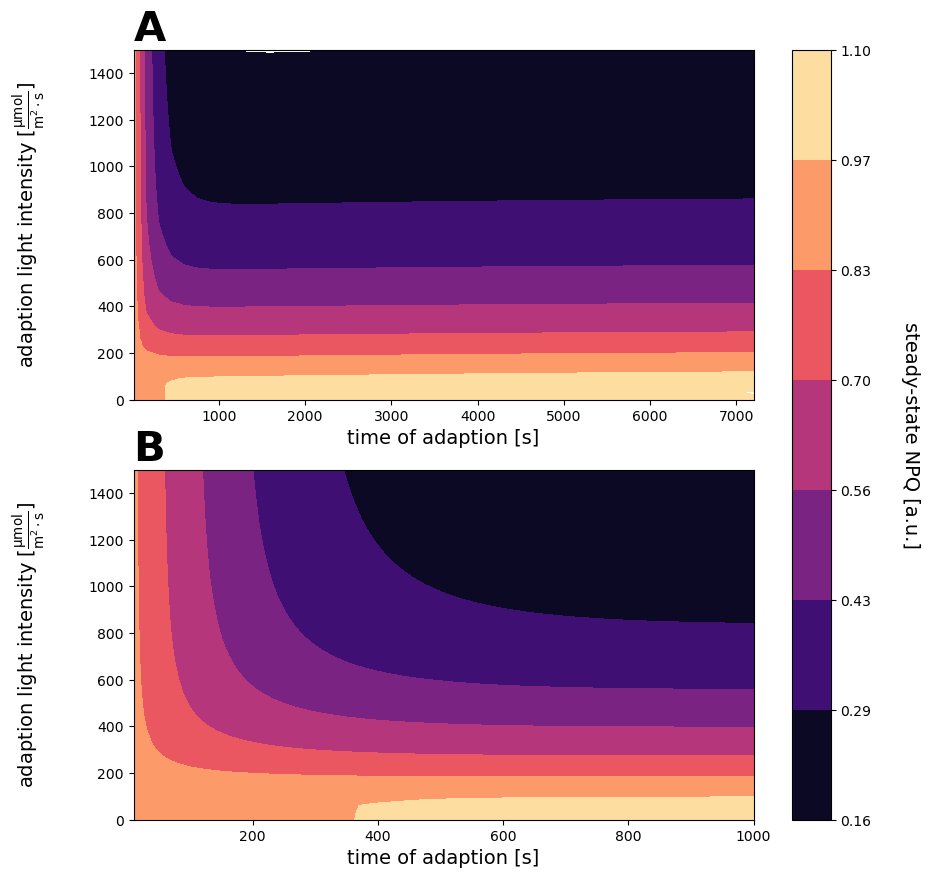

In [19]:
fig1, axs = plt.subplots(2,1,figsize=(10,10))
tcf = axs[0].tricontourf(time_list_long,pfd_list_long,NPQ_dict_long,cmap='magma', levels=np.around(np.linspace(min(NPQ_dict_long),max(NPQ_dict_long),8),2))
cbar = fig1.colorbar(tcf,ax=axs[:,])
cbar.set_label('steady-state NPQ [a.u.]', rotation=270, labelpad=35, size=14)
axs[0].set_title("A" , loc="left", fontdict={'fontsize': 30, 'fontweight': 'heavy'})
axs[0].set_xlabel("time of adaption [s]",color='k', size=14)
axs[0].set_ylabel(r"adaption light intensity [$\mathrm{\frac{\mu mol}{m^2 \cdot s}}$]", size=14, color='k', labelpad=30)
axs[0].tick_params(axis='x',labelcolor='k')
axs[0].tick_params(axis='y',labelcolor='k')
tcf2 = axs[1].tricontourf(time_list_short,pfd_list_short,NPQ_dict_short,cmap='magma',levels=np.around(np.linspace(min(NPQ_dict_long),max(NPQ_dict_long),8),2))

axs[1].set_title("B" , loc="left", fontdict={'fontsize': 30, 'fontweight': 'heavy'})
axs[1].set_xlabel("time of adaption [s]",color='k', size=14)
axs[1].set_ylabel(r"adaption light intensity [$\mathrm{\frac{\mu mol}{m^2 \cdot s}}$]", size=14, color='k', labelpad=30)
axs[1].tick_params(axis='x',labelcolor='k')
axs[1].tick_params(axis='y',labelcolor='k')
axs[1].set(xlim=(10,1000))

In [21]:
########################
## quencher parameter ##
#######################

In [22]:
"""
values of parameters to investigate
"gamma0": 0.1,  # slow quenching of (Vx - protonation)
"gamma1": 0.25,  # fast quenching (Vx + protonation)
"gamma2": 0.6,  # fastest possible quenching (Zx + protonation)
"gamma3": 0.15  # slow quenching of Zx present (Zx - protonation)
"kZSat":0.12 # half-saturation constant (relative conc. of Z) for quenching of Z
"""

'\nvalues of parameters to investigate\n"gamma0": 0.1,  # slow quenching of (Vx - protonation)\n"gamma1": 0.25,  # fast quenching (Vx + protonation)\n"gamma2": 0.6,  # fastest possible quenching (Zx + protonation)\n"gamma3": 0.15  # slow quenching of Zx present (Zx - protonation)\n"kZSat":0.12 # half-saturation constant (relative conc. of Z) for quenching of Z\n'

In [207]:
s1 = Simulator(m)
s1.initialise(y0)
s1.update_parameter("kcyc", 0.0)
pam_analysis(
            s1,
            t_relax=120,
            t_pulse=0.8,
            pfd_dark=50,
            pfd_illumination=1000,
            pfd_pulse=5000,
            adaption=10,
            time_adaption=10000
            )
Fm, NPQ, qPSII, tm, Fo, to = get_npq(s1)

adaption done with: 10000 and 10


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

In [208]:
plt.figure(figsize=(10, 5))
plt.plot(s1.get_full_results_df()["Fluo"]/max(s1.get_full_results_df()["Fluo"]), color="red")
plt.grid()
plt.xlim(10000,12500)
plt.axvspan(10000,10241.6,color="grey")
plt.axvspan(11450,12500, color="grey")
plt.ylabel("Fluorescence (normalised)")
plt.xlabel("Time [s]")
plt.xticks([10000,10250,10500,10750,11000,11250,11500,11750,12000,12250,12500],["0","250","500","750","1000","1250","1500","1750","2000","2250","2500"])

([<matplotlib.axis.XTick at 0x135966010>,
 [Text(10000, 0, '0'),
  Text(10250, 0, '250'),
  Text(10500, 0, '500'),
  Text(10750, 0, '750'),
  Text(11000, 0, '1000'),
  Text(11250, 0, '1250'),
  Text(11500, 0, '1500'),
  Text(11750, 0, '1750'),
  Text(12000, 0, '2000'),
  Text(12250, 0, '2250'),
  Text(12500, 0, '2500')])

In [12]:
### no adaption ###

s1 = Simulator(m)
s1.initialise(y0)
s1.update_parameter("gamma0",0.1)
s1.update_parameter("gamma1",0.25)
s1.update_parameter("gamma2",0.6)
s1.update_parameter("gamma3",0.15)
s1.update_parameter("kZSat",0.12)
max_NPQ=[]
NPQ_D_g0={}
NUM_SCANS = 10
MIN_LOG_F = -3.2
MAX_LOG_F = 3.2
slopei=[]
log2 = np.linspace(MIN_LOG_F, MAX_LOG_F, NUM_SCANS)
gamma0_npq =[]
gamma0_slope =[]
gamma1_npq =[]
gamma1_slope =[]
gamma2_npq=[]
gamma2_slope =[]
gamma3_npq=[]
gamma3_slope =[]
kZSat_npq=[]
kZSat_slope =[]
full_NPQ=[]
gamma0_full_NPQ=[]
gamma1_full_NPQ=[]
gamma2_full_NPQ=[]
gamma3_full_NPQ=[]
kZSat_full_NPQ=[]
gamma0_vals= m.parameters["gamma0"]*2**(log2)
gamma1_vals= m.parameters["gamma1"]*2**(log2)
gamma2_vals= m.parameters["gamma2"]*2**(log2)
gamma3_vals= m.parameters["gamma3"]*2**(log2)
kZSat_vals= m.parameters["kZSat"]*2**(log2)
d=0
gamma_vals=[gamma0_vals, gamma1_vals, gamma2_vals, gamma3_vals, kZSat_vals]
params=["gamma0","gamma1", "gamma2","gamma3","kZSat"]
for j in params:
    s1.update_parameter("gamma0",0.1)
    s1.update_parameter("gamma1",0.25)
    s1.update_parameter("gamma2",0.6)
    s1.update_parameter("gamma3",0.15)
    s1.update_parameter("kZSat",0.12)    
    for i in gamma_vals[d]:
        
        s1 = Simulator(m)
        s1.initialise(y0)
        s1.update_parameter(j,i)
        s1.update_parameter("kcyc",0)
        print(m.get_parameter("gamma0"),m.get_parameter("gamma1"),m.get_parameter("gamma2"),m.get_parameter("gamma3"), m.parameters["kZSat"])
        pam_analysis(
            s1,
            t_relax=120,
            t_pulse=0.8,
            pfd_dark=50,
            pfd_illumination=1000,
            pfd_pulse=5000,
            adaption=50,
            time_adaption=0)
        Fm, NPQ, qPSII, tm, Fo, to = get_npq(s1)
        max_NPQ.append(max(NPQ))
        full_NPQ.append(NPQ)
        slope_res=avg_slope(tm[:list(NPQ).index(max(NPQ))], NPQ[:list(NPQ).index(max(NPQ))])
        slopei.append(slope_res)
        print("finished", j, i, "and", slope_res)
    if j == "gamma0":
            gamma0_npq.append(max_NPQ)
            gamma0_slope.append(slopei)
            gamma0_full_NPQ.append(full_NPQ)
    if j == "gamma1":
            gamma1_npq.append(max_NPQ)
            gamma1_slope.append(slopei)
            gamma1_full_NPQ.append(full_NPQ)
    if j == "gamma2":
            gamma2_npq.append(max_NPQ)
            gamma2_slope.append(slopei)
            gamma2_full_NPQ.append(full_NPQ)
    if j == "gamma3":
            gamma3_npq.append(max_NPQ)
            gamma3_slope.append(slopei)
            gamma3_full_NPQ.append(full_NPQ)
    if j == "kZSat":
            kZSat_npq.append(max_NPQ)
            kZSat_slope.append(slopei)
            kZSat_full_NPQ.append(full_NPQ)
    max_NPQ=[]
    slopei=[]
    full_NPQ=[]
    d+=1
    print("fully finished", j)

0.010881882041201552 0.25 0.6 0.15 0.12
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma0 0.010881882041201552 and 0.0007027475342692837
0.01781434211969631 0.25 0.6 0.15 0.12
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma0 0.01781434211969631 and 0.0006997483528281724
0.029163225989402915 0.25 0.6 0.15 0.12
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma0 0.029163225989402915 and 0.000694933026656127
0.04774208019552082 0.25 0.6 0.15 0.12
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma0 0.04774208019552082 and 0.0006872553672174157
0.0781568617348361 0.25 0.6 0.15 0.12
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma0 0.0781568617348361 and 0.0006751244249413783
0.12794781901462657 0.25 0.6 0.15 0.12
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma0 0.12794781901462657 and 0.0006561114549574314
0.20945882456412532 0.25 0.6 0.15 0.12
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma0 0.20945882456412532 and 0.0006265084285815942
0.34289759314122914 0.25 0.6 0.15 0.12
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma0 0.34289759314122914 and 0.0005807503721389236
0.5613454559707578 0.25 0.6 0.15 0.12
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma0 0.5613454559707578 and 0.0005114862578637957
0.9189586839976281 0.25 0.6 0.15 0.12
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma0 0.9189586839976281 and 0.0004105268602386402
fully finished gamma0
0.1 0.027204705103003875 0.6 0.15 0.12
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma1 0.027204705103003875 and 0.0006562534014462755
0.1 0.04453585529924077 0.6 0.15 0.12
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma1 0.04453585529924077 and 0.0006570815808428776
0.1 0.07290806497350728 0.6 0.15 0.12
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma1 0.07290806497350728 and 0.0006584289045529873
0.1 0.11935520048880205 0.6 0.15 0.12
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma1 0.11935520048880205 and 0.0006606190207486886
0.1 0.19539215433709023 0.6 0.15 0.12
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma1 0.19539215433709023 and 0.0006641622702813634
0.1 0.31986954753656643 0.6 0.15 0.12
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma1 0.31986954753656643 and 0.0006698502281093988
0.1 0.5236470614103133 0.6 0.15 0.12
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma1 0.5236470614103133 and 0.0006788720092125257
0.1 0.8572439828530728 0.6 0.15 0.12
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma1 0.8572439828530728 and 0.0006928965357694913
0.1 1.4033636399268945 0.6 0.15 0.12
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma1 1.4033636399268945 and 0.0007140071067107578
0.1 2.29739670999407 0.6 0.15 0.12
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma1 2.29739670999407 and 0.0007441589170171597
fully finished gamma1
0.1 0.25 0.0652912922472093 0.15 0.12
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma2 0.0652912922472093 and 0.0006608180789347511
0.1 0.25 0.10688605271817785 0.15 0.12
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma2 0.10688605271817785 and 0.0006612788948076003
0.1 0.25 0.17497935593641747 0.15 0.12
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma2 0.17497935593641747 and 0.0006620335784049646
0.1 0.25 0.2864524811731249 0.15 0.12
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma2 0.2864524811731249 and 0.0006632624426219237
0.1 0.25 0.4689411704090165 0.15 0.12
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma2 0.4689411704090165 and 0.000665256105121893
0.1 0.25 0.7676869140877595 0.15 0.12
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma2 0.7676869140877595 and 0.00066847159511798
0.1 0.25 1.2567529473847519 0.15 0.12
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma2 1.2567529473847519 and 0.0006736176187943656
0.1 0.25 2.0573855588473746 0.15 0.12
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma2 2.0573855588473746 and 0.0006817223409124876
0.1 0.25 3.368072735824547 0.15 0.12
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma2 3.368072735824547 and 0.0006941903043723763
0.1 0.25 5.513752103985769 0.15 0.12
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma2 5.513752103985769 and 0.000712632500110342
fully finished gamma2
0.1 0.25 0.6 0.016322823061802324 0.12
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma3 0.016322823061802324 and 0.0006969205348220851
0.1 0.25 0.6 0.02672151317954446 0.12
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma3 0.02672151317954446 and 0.0006943504111666531
0.1 0.25 0.6 0.04374483898410437 0.12
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma3 0.04374483898410437 and 0.0006902314062735995
0.1 0.25 0.6 0.07161312029328122 0.12
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma3 0.07161312029328122 and 0.000683710686908851
0.1 0.25 0.6 0.11723529260225413 0.12
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma3 0.11723529260225413 and 0.000673579196959666
0.1 0.25 0.6 0.19192172852193987 0.12
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma3 0.19192172852193987 and 0.0006582397397112646
0.1 0.25 0.6 0.31418823684618796 0.12
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma3 0.31418823684618796 and 0.0006977245604722967
0.1 0.25 0.6 0.5143463897118437 0.12
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma3 0.5143463897118437 and 0.0006639023156952928
0.1 0.25 0.6 0.8420181839561367 0.12
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma3 0.8420181839561367 and 0.0006843524875486868
0.1 0.25 0.6 1.3784380259964422 0.12
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma3 1.3784380259964422 and 0.0006276159872911778
fully finished gamma3
0.1 0.25 0.6 0.15 0.01305825844944186
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished kZSat 0.01305825844944186 and 0.0006478052796536524
0.1 0.25 0.6 0.15 0.021377210543635568
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished kZSat 0.021377210543635568 and 0.0006495847737413591
0.1 0.25 0.6 0.15 0.03499587118728349
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished kZSat 0.03499587118728349 and 0.0006526531765397528
0.1 0.25 0.6 0.15 0.05729049623462498
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished kZSat 0.05729049623462498 and 0.0006573070606770895
0.1 0.25 0.6 0.15 0.09378823408180331
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished kZSat 0.09378823408180331 and 0.0006633548578806664
0.1 0.25 0.6 0.15 0.1535373828175519
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished kZSat 0.1535373828175519 and 0.0006700212818126231
0.1 0.25 0.6 0.15 0.2513505894769503
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished kZSat 0.2513505894769503 and 0.0006763175370278272
0.1 0.25 0.6 0.15 0.41147711176947493
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished kZSat 0.41147711176947493 and 0.0006815436465044976
0.1 0.25 0.6 0.15 0.6736145471649093
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished kZSat 0.6736145471649093 and 0.0006854656038639538
0.1 0.25 0.6 0.15 1.1027504207971537
adaption done with: 0 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished kZSat 1.1027504207971537 and 0.0006882081998601612
fully finished kZSat


In [33]:
listis = []
for i in log2:
    listis.append(str(round(i,2)))
paramters=[]
for i in range(0,5):
    b=params[i]
    for j in range(0,10):
        paramters.append(b)
slope=[*gamma0_slope,*gamma1_slope,*gamma2_slope,*gamma3_slope,*kZSat_slope]
slope=list(it.chain.from_iterable(slope))
df=pd.DataFrame({"parameters":paramters, "slope": slope})


color = cm.rainbow(np.linspace(0, 1, 10))
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 10))
ax1.set_title("A" , loc="left", fontdict={'fontsize': 30, 'fontweight': 'heavy'})
ax1.scatter(listis,gamma0_npq, label="$\gamma_0$", )
ax1.scatter(listis,gamma1_npq, label="$\gamma_1$",)
ax1.scatter(listis,gamma2_npq, label="$\gamma_2$", )
ax1.scatter(listis,gamma3_npq, label="$\gamma_3$", )
ax1.scatter(listis,kZSat_npq, label="$k_{ZSat}$", )
ax1.set_xlabel("log2 fold change", fontsize=12)
ax1.set_ylabel("maximal NPQ", fontsize=12)
#ax1.legend()
ax1.grid(axis="y")
ax1.set(
    xlabel="Log$_2$ fold change",
    ylabel="maximal NPQ",
)
ax2.set_title("B" , loc="left", fontdict={'fontsize': 30, 'fontweight': 'heavy'})
ax2.scatter(listis,gamma0_slope)#, label="gamma0", )
ax2.scatter(listis,gamma1_slope)#, label="gamma1",)
ax2.scatter(listis,gamma2_slope)#, label="gamma2", )
ax2.scatter(listis,gamma3_slope)#, label="gamma3", )
ax2.scatter(listis,kZSat_slope)#, label="kZSat", )
#ax2.legend()
ax2.set_xlabel("Log$_2$ fold change", fontsize=12)
ax2.set_ylabel("average NPQ/s", fontsize=12)
ax2.grid(axis="y")
#ax2.set(
#    xlabel="Quencher parameters log2 fold change",
#    ylabel="NPQ/s",)
fig.legend(loc="center right",  bbox_to_anchor=(1.1, 0.5), fontsize=12)
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.3)
#plt.xticks(listis)
#ax.legend(loc="upper right",  bbox_to_anchor=(1.2, 1))

In [14]:
s1 = Simulator(m)
s1.initialise(y0)
s1.update_parameter("gamma0",0.1*2**-3.2)
s1.update_parameter("gamma1",0.25*2**3.2)
s1.update_parameter("gamma2",0.6*2**3.2)
s1.update_parameter("gamma3",0.15*2**-3.2)
s1.update_parameter("kZSat",0.12*2**3.2)
s1.update_parameter("ATPturnover",71)
s1.update_parameter("pKreg",6.2)
s1.update_parameter("kcyc",0)
pam_analysis(
            s1,
            t_relax=120,
            t_pulse=0.8,
            pfd_dark=50,
            pfd_illumination=1000,
            pfd_pulse=5000,
            adaption=1,
            time_adaption=10000)
Fm, NPQ, qPSII, tm, Fo, to = get_npq(s1)

adaption done with: 10000 and 1


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

([<matplotlib.axis.XTick at 0x137086010>,
 [Text(10000, 0, '0'),
  Text(10250, 0, '250'),
  Text(10500, 0, '500'),
  Text(10750, 0, '750'),
  Text(11000, 0, '1000'),
  Text(11250, 0, '1250'),
  Text(11500, 0, '1500'),
  Text(11750, 0, '1750'),
  Text(12000, 0, '2000'),
  Text(12250, 0, '2250'),
  Text(12500, 0, '2500')])

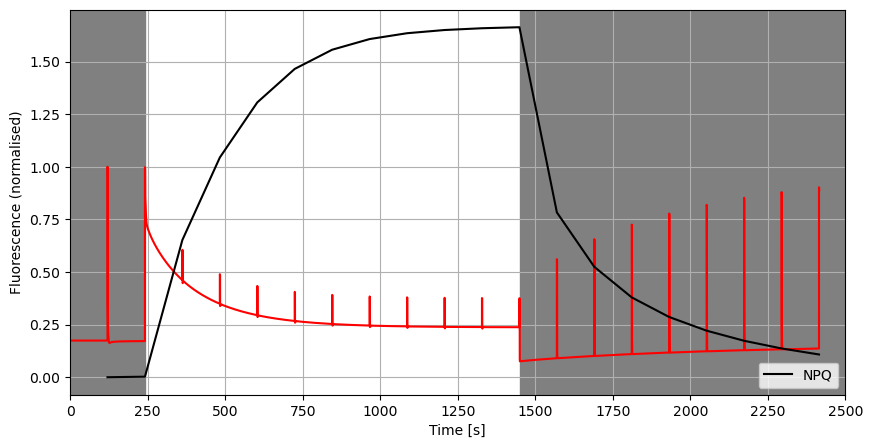

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(s1.get_full_results_df()["Fluo"]/max(s1.get_full_results_df()["Fluo"]), color="red")
plt.plot(tm, NPQ, color="black", label="NPQ")
plt.grid()
plt.xlabel("Time/(s)")
plt.ylabel("Fluorescence (normalised)")

plt.legend(loc="lower right")
plt.savefig("fig-2.png", bbox_inches="tight")
plt.xlim(10000,12500)
plt.axvspan(10000,10241.6,color="grey")
plt.axvspan(11450,12500, color="grey")
plt.ylabel("Fluorescence (normalised)")
plt.xlabel("Time [s]")
plt.xticks([10000,10250,10500,10750,11000,11250,11500,11750,12000,12250,12500],["0","250","500","750","1000","1250","1500","1750","2000","2250","2500"])

In [123]:
s1 = Simulator(m)
s1.initialise(y0)
s1.update_parameter("gamma0",0.1*2**-3.5)
s1.update_parameter("gamma1",0.25*2**3.7)
s1.update_parameter("gamma2",0.6*2**3.7)
s1.update_parameter("gamma3",0.15*2**-3.5)
s1.update_parameter("kZSat",0.12*2**-3.2)
s1.update_parameter("ATPturnover",71)
s1.update_parameter("pKreg", 6.2)
s1.update_parameter("kcyc",1)
c, v = s1.parameter_scan_with_fluxes("pfd",
                        parameter_values=np.linspace(50, 1500, 50),
                        multiprocessing=False,
                        **{'atol': 1.e-20})

pfd:   0%|          | 0/50 [00:00<?, ?it/s]

In [124]:
def plot_ppfd_petc_steady_state1(
    v: pd.DataFrame, c:pd.DataFrame, ax1: Optional[plt.Axes] = None
) -> Tuple[plt.Axes, plt.Axes]:
    if ax1 is None:
        _, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    v["vPS1"].plot(ax=ax1, label="rate through PS1")
    (v["vPS2"] * 2).plot(ax=ax1, label="LEF")
    (v["vCyc"] * 2).plot(ax=ax1, label="CEF")
    ax1.set(
        xlabel="PPFD/($\mu$mol m$^{-2}$s$^{-1}$)",
        ylabel="mmol e$^-$/mol Chl/s",
    )
    ax2.plot(c["pH"], "r--", label="pH")
    ax2.set(xlabel="PPFD")
    ax2.set_ylabel("pH", color="red"),
    ax2.tick_params(axis="y", labelcolor="red")
    return ax1, ax2


def plot_ppfd_redox_steady_state1(
    c: pd.DataFrame, ax1: Optional[plt.Axes] = None
) -> Tuple[plt.Axes, plt.Axes]:
    if ax1 is None:
        _, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    c["ATP_norm"].plot(ax=ax1, label="ATP", color="C0")
    c["NADP_redoxstate"].plot(ax=ax1, label="NADPH", color="C1")
    c["Fd_redoxstate"].plot(ax=ax1, label="reduced Fd", color="C2")
    c["PQ_redoxstate"].plot(ax=ax1, label="reduced PQ", color="C4")
    c["PC_redoxstate"].plot(ax=ax1, label="reduced PC", color="C5")
    ax1.set(xlabel="PPFD/($\mu$mol m$^{-2}$s$^{-1}$)", ylabel="Fraction of the pool")
    ax2.plot(c["H2O2"], "r--", label="H$_2$O$_2$")
    ax2.set_xlabel("PPFD/($\mu$mol\,m$^{-2}$s$^{-1}$)")
    ax2.set_ylabel("Concentration/mM", color="red")
    ax2.tick_params(axis="y", labelcolor="red")
    return ax1, ax2

In [125]:
fig, (ax1, ax2) = plt.subplots(2,1 , figsize=(8,10))
ax1.plot(v["vB6f"], label="B6f complex")
(ax11, ax12)=plot_ppfd_petc_steady_state1(v,c, ax1)
ax12.legend(loc="lower right", borderaxespad=0.5)
(ax21, ax22) = plot_ppfd_redox_steady_state1(c, ax2)
ax22.legend(loc="lower right", borderaxespad=0.5)
fig.tight_layout(w_pad=5)
lines_labels = [ax.get_legend_handles_labels() for ax in [fig.axes[0]]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend()
ax2.legend(loc="upper left")
ax1.set_title("photosynthetic elecron flux")
ax2.set_title("redox and energy status")
plt.show()

In [13]:
### low light adaption ###

s1 = Simulator(m)
s1.initialise(y0)
s1.update_parameter("gamma0",0.1)
s1.update_parameter("gamma1",0.25)
s1.update_parameter("gamma2",0.6)
s1.update_parameter("gamma3",0.15)
s1.update_parameter("kZSat",0.12)
max_NPQ=[]
NPQ_D_g0={}
NUM_SCANS = 10
MIN_LOG_F = -3.2
MAX_LOG_F = 3.2
slopei=[]
log2 = np.linspace(MIN_LOG_F, MAX_LOG_F, NUM_SCANS)
gamma0_npq_50 =[]
gamma0_slope_50 =[]
gamma1_npq_50 =[]
gamma1_slope_50 =[]
gamma2_npq_50=[]
gamma2_slope_50 =[]
gamma3_npq_50=[]
gamma3_slope_50 =[]
kZSat_npq_50=[]
kZSat_slope_50 =[]
gamma0_vals= m.parameters["gamma0"]*2**(log2)
gamma1_vals= m.parameters["gamma1"]*2**(log2)
gamma2_vals= m.parameters["gamma2"]*2**(log2)
gamma3_vals= m.parameters["gamma3"]*2**(log2)
kZSat_vals= m.parameters["kZSat"]*2**(log2)
d=0
gamma_vals=[gamma0_vals, gamma1_vals, gamma2_vals, gamma3_vals, kZSat_vals]
params=["gamma0","gamma1", "gamma2","gamma3","kZSat"]
for j in params:
    s1.update_parameter("gamma0",0.1)
    s1.update_parameter("gamma1",0.25)
    s1.update_parameter("gamma2",0.6)
    s1.update_parameter("gamma3",0.15)
    s1.update_parameter("kZSat",0.12)    
    for i in gamma_vals[d]:
        
        s1 = Simulator(m)
        s1.initialise(y0)
        s1.update_parameter(j,i)
        s1.update_parameter("kcyc",0)
        print(m.get_parameter("gamma0"),m.get_parameter("gamma1"),m.get_parameter("gamma2"),m.get_parameter("gamma3"), m.parameters["kZSat"])
        pam_analysis(
            s1,
            t_relax=120,
            t_pulse=0.8,
            pfd_dark=50,
            pfd_illumination=1000,
            pfd_pulse=5000,
            adaption=50,
            time_adaption=10000)
        Fm, NPQ, qPSII, tm, Fo, to = get_npq(s1)
        max_NPQ.append(max(NPQ))
        slope_res=avg_slope(tm[:list(NPQ).index(max(NPQ))], NPQ[:list(NPQ).index(max(NPQ))])
        slopei.append(slope_res)
        print("finished", j, i, "and", slope_res)
    if j == "gamma0":
            gamma0_npq_50.append(max_NPQ)
            gamma0_slope_50.append(slopei)
    if j == "gamma1":
            gamma1_npq_50.append(max_NPQ)
            gamma1_slope_50.append(slopei)
    if j == "gamma2":
            gamma2_npq_50.append(max_NPQ)
            gamma2_slope_50.append(slopei)
    if j == "gamma3":
            gamma3_npq_50.append(max_NPQ)
            gamma3_slope_50.append(slopei)
    if j == "kZSat":
            kZSat_npq_50.append(max_NPQ)
            kZSat_slope_50.append(slopei)
    max_NPQ=[]
    slopei=[]
    d+=1
    print("fully finished", j)

0.010881882041201552 0.25 0.6 0.15 0.12
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma0 0.010881882041201552 and 0.0008795399871909912
0.01781434211969631 0.25 0.6 0.15 0.12
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma0 0.01781434211969631 and 0.0008731201844542302
0.029163225989402915 0.25 0.6 0.15 0.12
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma0 0.029163225989402915 and 0.0008636583287754902
0.04774208019552082 0.25 0.6 0.15 0.12
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma0 0.04774208019552082 and 0.000850388115810028
0.0781568617348361 0.25 0.6 0.15 0.12
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma0 0.0781568617348361 and 0.000832830712072925
0.12794781901462657 0.25 0.6 0.15 0.12
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma0 0.12794781901462657 and 0.0008103216348544017
0.20945882456412532 0.25 0.6 0.15 0.12
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma0 0.20945882456412532 and 0.0007746081450329245
0.34289759314122914 0.25 0.6 0.15 0.12
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma0 0.34289759314122914 and 0.000710756312319225
0.5613454559707578 0.25 0.6 0.15 0.12
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma0 0.5613454559707578 and 0.000622146290932932
0.9189586839976281 0.25 0.6 0.15 0.12
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma0 0.9189586839976281 and 0.0005033358873886063
fully finished gamma0
0.1 0.027204705103003875 0.6 0.15 0.12
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma1 0.027204705103003875 and 0.0007979351203356928
0.1 0.04453585529924077 0.6 0.15 0.12
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma1 0.04453585529924077 and 0.0007998559579294156
0.1 0.07290806497350728 0.6 0.15 0.12
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma1 0.07290806497350728 and 0.0008029908743116081
0.1 0.11935520048880205 0.6 0.15 0.12
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma1 0.11935520048880205 and 0.0008081000498123985
0.1 0.19539215433709023 0.6 0.15 0.12
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma1 0.19539215433709023 and 0.0008163993799735814
0.1 0.31986954753656643 0.6 0.15 0.12
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma1 0.31986954753656643 and 0.0008298221237052901
0.1 0.5236470614103133 0.6 0.15 0.12
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma1 0.5236470614103133 and 0.0008513528247109536
0.1 0.8572439828530728 0.6 0.15 0.12
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma1 0.8572439828530728 and 0.000885464024428587
0.1 1.4033636399268945 0.6 0.15 0.12
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma1 1.4033636399268945 and 0.0009384111827442868
0.1 2.29739670999407 0.6 0.15 0.12
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma1 2.29739670999407 and 0.0010179283800564247
fully finished gamma1
0.1 0.25 0.0652912922472093 0.15 0.12
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma2 0.0652912922472093 and 0.000813861908256338
0.1 0.25 0.10688605271817785 0.15 0.12
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma2 0.10688605271817785 and 0.0008145210662849931
0.1 0.25 0.17497935593641747 0.15 0.12
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma2 0.17497935593641747 and 0.0008155990123680197
0.1 0.25 0.2864524811731249 0.15 0.12
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma2 0.2864524811731249 and 0.000817362661241948
0.1 0.25 0.4689411704090165 0.15 0.12
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma2 0.4689411704090165 and 0.000820245750340626
0.1 0.25 0.7676869140877595 0.15 0.12
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma2 0.7676869140877595 and 0.000824952714189775
0.1 0.25 1.2567529473847519 0.15 0.12
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma2 1.2567529473847519 and 0.0008326287106387577
0.1 0.25 2.0573855588473746 0.15 0.12
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma2 2.0573855588473746 and 0.0008451094981518449
0.1 0.25 3.368072735824547 0.15 0.12
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma2 3.368072735824547 and 0.0008653204384599143
0.1 0.25 5.513752103985769 0.15 0.12
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma2 5.513752103985769 and 0.0008978191164499272
fully finished gamma2
0.1 0.25 0.6 0.016322823061802324 0.12
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma3 0.016322823061802324 and 0.0007960278229304364
0.1 0.25 0.6 0.02672151317954446 0.12
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma3 0.02672151317954446 and 0.0007981724597036236
0.1 0.25 0.6 0.04374483898410437 0.12
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma3 0.04374483898410437 and 0.0008016445948757361
0.1 0.25 0.6 0.07161312029328122 0.12
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma3 0.07161312029328122 and 0.0008072314984547663
0.1 0.25 0.6 0.11723529260225413 0.12
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma3 0.11723529260225413 and 0.0008161213826873025
0.1 0.25 0.6 0.19192172852193987 0.12
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma3 0.19192172852193987 and 0.0008300117986795798
0.1 0.25 0.6 0.31418823684618796 0.12
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma3 0.31418823684618796 and 0.0008511047387476785
0.1 0.25 0.6 0.5143463897118437 0.12
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma3 0.5143463897118437 and 0.0008816802965345965
0.1 0.25 0.6 0.8420181839561367 0.12
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma3 0.8420181839561367 and 0.000922587897812159
0.1 0.25 0.6 1.3784380259964422 0.12
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma3 1.3784380259964422 and 0.0009685894000378322
fully finished gamma3
0.1 0.25 0.6 0.15 0.01305825844944186
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished kZSat 0.01305825844944186 and 0.000874538882966389
0.1 0.25 0.6 0.15 0.021377210543635568
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished kZSat 0.021377210543635568 and 0.0008744546002773108
0.1 0.25 0.6 0.15 0.03499587118728349
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished kZSat 0.03499587118728349 and 0.0008639761555883876
0.1 0.25 0.6 0.15 0.05729049623462498
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished kZSat 0.05729049623462498 and 0.0008474869879737582
0.1 0.25 0.6 0.15 0.09378823408180331
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished kZSat 0.09378823408180331 and 0.0008301512266622918
0.1 0.25 0.6 0.15 0.1535373828175519
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished kZSat 0.1535373828175519 and 0.0008153341621763832
0.1 0.25 0.6 0.15 0.2513505894769503
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished kZSat 0.2513505894769503 and 0.0008041688047647359
0.1 0.25 0.6 0.15 0.41147711176947493
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished kZSat 0.41147711176947493 and 0.0007963943743789284
0.1 0.25 0.6 0.15 0.6736145471649093
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished kZSat 0.6736145471649093 and 0.0007912463301430004
0.1 0.25 0.6 0.15 1.1027504207971537
adaption done with: 10000 and 50


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished kZSat 1.1027504207971537 and 0.000787939395925205
fully finished kZSat


In [14]:
### mid light adaption ###

s1 = Simulator(m)
s1.initialise(y0)
s1.update_parameter("gamma0",0.1)
s1.update_parameter("gamma1",0.25)
s1.update_parameter("gamma2",0.6)
s1.update_parameter("gamma3",0.15)
s1.update_parameter("kZSat",0.12)
max_NPQ=[]
NPQ_D_g0={}
NUM_SCANS = 10
MIN_LOG_F = -3.2
MAX_LOG_F = 3.2
slopei=[]
log2 = np.linspace(MIN_LOG_F, MAX_LOG_F, NUM_SCANS)
gamma0_npq_600 =[]
gamma0_slope_600 =[]
gamma1_npq_600 =[]
gamma1_slope_600 =[]
gamma2_npq_600=[]
gamma2_slope_600 =[]
gamma3_npq_600=[]
gamma3_slope_600 =[]
kZSat_npq_600=[]
kZSat_slope_600 =[]
gamma0_vals= m.parameters["gamma0"]*2**(log2)
gamma1_vals= m.parameters["gamma1"]*2**(log2)
gamma2_vals= m.parameters["gamma2"]*2**(log2)
gamma3_vals= m.parameters["gamma3"]*2**(log2)
kZSat_vals= m.parameters["kZSat"]*2**(log2)
d=0
gamma_vals=[gamma0_vals, gamma1_vals, gamma2_vals, gamma3_vals, kZSat_vals]
params=["gamma0","gamma1", "gamma2","gamma3","kZSat"]
for j in params:
    s1.update_parameter("gamma0",0.1)
    s1.update_parameter("gamma1",0.25)
    s1.update_parameter("gamma2",0.6)
    s1.update_parameter("gamma3",0.15)
    s1.update_parameter("kZSat",0.12)    
    for i in gamma_vals[d]:
        
        s1 = Simulator(m)
        s1.initialise(y0)
        s1.update_parameter(j,i)
        s1.update_parameter("kcyc",0)
        print(m.get_parameter("gamma0"),m.get_parameter("gamma1"),m.get_parameter("gamma2"),m.get_parameter("gamma3"), m.parameters["kZSat"])
        pam_analysis(
            s1,
            t_relax=120,
            t_pulse=0.8,
            pfd_dark=50,
            pfd_illumination=1000,
            pfd_pulse=5000,
            adaption=600,
            time_adaption=10000)
        Fm, NPQ, qPSII, tm, Fo, to = get_npq(s1)
        max_NPQ.append(max(NPQ))
        slope_res=avg_slope(tm[:list(NPQ).index(max(NPQ))], NPQ[:list(NPQ).index(max(NPQ))])
        slopei.append(slope_res)
        print("finished", j, i, "and", slope_res)
    if j == "gamma0":
            gamma0_npq_600.append(max_NPQ)
            gamma0_slope_600.append(slopei)
    if j == "gamma1":
            gamma1_npq_600.append(max_NPQ)
            gamma1_slope_600.append(slopei)
    if j == "gamma2":
            gamma2_npq_600.append(max_NPQ)
            gamma2_slope_600.append(slopei)
    if j == "gamma3":
            gamma3_npq_600.append(max_NPQ)
            gamma3_slope_600.append(slopei)
    if j == "kZSat":
            kZSat_npq_600.append(max_NPQ)
            kZSat_slope_600.append(slopei)
    max_NPQ=[]
    slopei=[]
    d+=1
    print("fully finished", j)

0.010881882041201552 0.25 0.6 0.15 0.12
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma0 0.010881882041201552 and 0.000333049790959112
0.01781434211969631 0.25 0.6 0.15 0.12
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma0 0.01781434211969631 and 0.00033086753451898164
0.029163225989402915 0.25 0.6 0.15 0.12
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma0 0.029163225989402915 and 0.00032756879093536373
0.04774208019552082 0.25 0.6 0.15 0.12
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma0 0.04774208019552082 and 0.00032280536267025
0.0781568617348361 0.25 0.6 0.15 0.12
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma0 0.0781568617348361 and 0.00031639758798593674
0.12794781901462657 0.25 0.6 0.15 0.12
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma0 0.12794781901462657 and 0.0003085031815536808
0.20945882456412532 0.25 0.6 0.15 0.12
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma0 0.20945882456412532 and 0.00029948360648989316
0.34289759314122914 0.25 0.6 0.15 0.12
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma0 0.34289759314122914 and 0.0002893856080884401
0.5613454559707578 0.25 0.6 0.15 0.12
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma0 0.5613454559707578 and 0.0002769518685653453
0.9189586839976281 0.25 0.6 0.15 0.12
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma0 0.9189586839976281 and 0.0002586959519687191
fully finished gamma0
0.1 0.027204705103003875 0.6 0.15 0.12
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma1 0.027204705103003875 and 0.0002996560445730473
0.1 0.04453585529924077 0.6 0.15 0.12
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma1 0.04453585529924077 and 0.00030067808230182575
0.1 0.07290806497350728 0.6 0.15 0.12
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma1 0.07290806497350728 and 0.0003023448720964572
0.1 0.11935520048880205 0.6 0.15 0.12
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma1 0.11935520048880205 and 0.0003050611672500467
0.1 0.19539215433709023 0.6 0.15 0.12
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma1 0.19539215433709023 and 0.00030947329278553523
0.1 0.31986954753656643 0.6 0.15 0.12
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma1 0.31986954753656643 and 0.00031660111046116204
0.1 0.5236470614103133 0.6 0.15 0.12
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma1 0.5236470614103133 and 0.00032802418706431115
0.1 0.8572439828530728 0.6 0.15 0.12
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma1 0.8572439828530728 and 0.00034608805117032447
0.1 1.4033636399268945 0.6 0.15 0.12
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma1 1.4033636399268945 and 0.000374062604008919
0.1 2.29739670999407 0.6 0.15 0.12
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma1 2.29739670999407 and 0.00041597418241050255
fully finished gamma1
0.1 0.25 0.0652912922472093 0.15 0.12
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma2 0.0652912922472093 and 0.00030511200416271283
0.1 0.25 0.10688605271817785 0.15 0.12
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma2 0.10688605271817785 and 0.00030569858420122285
0.1 0.25 0.17497935593641747 0.15 0.12
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma2 0.17497935593641747 and 0.0003066598639940565
0.1 0.25 0.2864524811731249 0.15 0.12
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma2 0.2864524811731249 and 0.0003082284014798443
0.1 0.25 0.4689411704090165 0.15 0.12
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma2 0.4689411704090165 and 0.00031078578541218147
0.1 0.25 0.7676869140877595 0.15 0.12
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma2 0.7676869140877595 and 0.00031494710842403445
0.1 0.25 1.2567529473847519 0.15 0.12
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma2 1.2567529473847519 and 0.0003216904014923498
0.1 0.25 2.0573855588473746 0.15 0.12
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma2 2.0573855588473746 and 0.00033254852095103703
0.1 0.25 3.368072735824547 0.15 0.12
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma2 3.368072735824547 and 0.000349861594726015
0.1 0.25 5.513752103985769 0.15 0.12
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma2 5.513752103985769 and 0.00037701075066308746
fully finished gamma2
0.1 0.25 0.6 0.016322823061802324 0.12
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma3 0.016322823061802324 and 0.0003047668163081635
0.1 0.25 0.6 0.02672151317954446 0.12
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma3 0.02672151317954446 and 0.0003054110611472417
0.1 0.25 0.6 0.04374483898410437 0.12
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma3 0.04374483898410437 and 0.0003064543209753896
0.1 0.25 0.6 0.07161312029328122 0.12
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma3 0.07161312029328122 and 0.0003081256565082752
0.1 0.25 0.6 0.11723529260225413 0.12
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma3 0.11723529260225413 and 0.0003107759631153881
0.1 0.25 0.6 0.19192172852193987 0.12
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma3 0.19192172852193987 and 0.0003148940018487037
0.1 0.25 0.6 0.31418823684618796 0.12
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma3 0.31418823684618796 and 0.00032110960513854575
0.1 0.25 0.6 0.5143463897118437 0.12
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma3 0.5143463897118437 and 0.00033010491753308
0.1 0.25 0.6 0.8420181839561367 0.12
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma3 0.8420181839561367 and 0.0003423861914008656
0.1 0.25 0.6 1.3784380259964422 0.12
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma3 1.3784380259964422 and 0.0003578370336640021
fully finished gamma3
0.1 0.25 0.6 0.15 0.01305825844944186
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished kZSat 0.01305825844944186 and 0.0003208909128306588
0.1 0.25 0.6 0.15 0.021377210543635568
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished kZSat 0.021377210543635568 and 0.0003226988250924737
0.1 0.25 0.6 0.15 0.03499587118728349
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished kZSat 0.03499587118728349 and 0.00032244918111952047
0.1 0.25 0.6 0.15 0.05729049623462498
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished kZSat 0.05729049623462498 and 0.00031973482001699865
0.1 0.25 0.6 0.15 0.09378823408180331
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished kZSat 0.09378823408180331 and 0.0003151895056740458
0.1 0.25 0.6 0.15 0.1535373828175519
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished kZSat 0.1535373828175519 and 0.0003100485267194454
0.1 0.25 0.6 0.15 0.2513505894769503
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished kZSat 0.2513505894769503 and 0.0003053840789616555
0.1 0.25 0.6 0.15 0.41147711176947493
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished kZSat 0.41147711176947493 and 0.0003017123603086138
0.1 0.25 0.6 0.15 0.6736145471649093
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished kZSat 0.6736145471649093 and 0.0002990776064619619
0.1 0.25 0.6 0.15 1.1027504207971537
adaption done with: 10000 and 600


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished kZSat 1.1027504207971537 and 0.00029729775461903894
fully finished kZSat


In [15]:
### high light adaption ###

s1 = Simulator(m)
s1.initialise(y0)
s1.update_parameter("gamma0",0.1)
s1.update_parameter("gamma1",0.25)
s1.update_parameter("gamma2",0.6)
s1.update_parameter("gamma3",0.15)
s1.update_parameter("kZSat",0.12)
max_NPQ=[]
NPQ_D_g0={}
NUM_SCANS = 10
MIN_LOG_F = -3.2
MAX_LOG_F = 3.2
slopei=[]
log2 = np.linspace(MIN_LOG_F, MAX_LOG_F, NUM_SCANS)
gamma0_npq_1200 =[]
gamma0_slope_1200 =[]
gamma1_npq_1200 =[]
gamma1_slope_1200 =[]
gamma2_npq_1200=[]
gamma2_slope_1200 =[]
gamma3_npq_1200=[]
gamma3_slope_1200 =[]
kZSat_npq_1200=[]
kZSat_slope_1200 =[]
gamma0_vals= m.parameters["gamma0"]*2**(log2)
gamma1_vals= m.parameters["gamma1"]*2**(log2)
gamma2_vals= m.parameters["gamma2"]*2**(log2)
gamma3_vals= m.parameters["gamma3"]*2**(log2)
kZSat_vals= m.parameters["kZSat"]*2**(log2)
d=0
gamma_vals=[gamma0_vals, gamma1_vals, gamma2_vals, gamma3_vals, kZSat_vals]
params=["gamma0","gamma1", "gamma2","gamma3","kZSat"]
for j in params:
    s1.update_parameter("gamma0",0.1)
    s1.update_parameter("gamma1",0.25)
    s1.update_parameter("gamma2",0.6)
    s1.update_parameter("gamma3",0.15)
    s1.update_parameter("kZSat",0.12)    
    for i in gamma_vals[d]:
        
        s1 = Simulator(m)
        s1.initialise(y0)
        s1.update_parameter(j,i)
        s1.update_parameter("kcyc",0)
        print(m.get_parameter("gamma0"),m.get_parameter("gamma1"),m.get_parameter("gamma2"),m.get_parameter("gamma3"), m.parameters["kZSat"])
        pam_analysis(
            s1,
            t_relax=120,
            t_pulse=0.8,
            pfd_dark=50,
            pfd_illumination=1000,
            pfd_pulse=5000,
            adaption=1200,
            time_adaption=10000)
        Fm, NPQ, qPSII, tm, Fo, to = get_npq(s1)
        max_NPQ.append(max(NPQ))
        slope_res=avg_slope(tm[:list(NPQ).index(max(NPQ))], NPQ[:list(NPQ).index(max(NPQ))])
        slopei.append(slope_res)
        print("finished", j, i, "and", slope_res)
    if j == "gamma0":
            gamma0_npq_1200.append(max_NPQ)
            gamma0_slope_1200.append(slopei)
    if j == "gamma1":
            gamma1_npq_1200.append(max_NPQ)
            gamma1_slope_1200.append(slopei)
    if j == "gamma2":
            gamma2_npq_1200.append(max_NPQ)
            gamma2_slope_1200.append(slopei)
    if j == "gamma3":
            gamma3_npq_1200.append(max_NPQ)
            gamma3_slope_1200.append(slopei)
    if j == "kZSat":
            kZSat_npq_1200.append(max_NPQ)
            kZSat_slope_1200.append(slopei)
    max_NPQ=[]
    slopei=[]
    d+=1
    print("fully finished", j)

0.010881882041201552 0.25 0.6 0.15 0.12
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma0 0.010881882041201552 and 0.00019641436259649285
0.01781434211969631 0.25 0.6 0.15 0.12
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma0 0.01781434211969631 and 0.0001937766491327038
0.029163225989402915 0.25 0.6 0.15 0.12
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma0 0.029163225989402915 and 0.0001897341751541589
0.04774208019552082 0.25 0.6 0.15 0.12
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma0 0.04774208019552082 and 0.00018374630041017957
0.0781568617348361 0.25 0.6 0.15 0.12
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma0 0.0781568617348361 and 0.00017522660523697792
0.12794781901462657 0.25 0.6 0.15 0.12
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma0 0.12794781901462657 and 0.0001636327496948085
0.20945882456412532 0.25 0.6 0.15 0.12
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma0 0.20945882456412532 and 0.00013523492134674564
0.34289759314122914 0.25 0.6 0.15 0.12
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma0 0.34289759314122914 and 0.00011738444984712687
0.5613454559707578 0.25 0.6 0.15 0.12
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma0 0.5613454559707578 and 9.446080043083206e-05
0.9189586839976281 0.25 0.6 0.15 0.12
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma0 0.9189586839976281 and 1.9677172988317665e-05
fully finished gamma0
0.1 0.027204705103003875 0.6 0.15 0.12
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma1 0.027204705103003875 and 0.00015996604348829908
0.1 0.04453585529924077 0.6 0.15 0.12
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma1 0.04453585529924077 and 0.00016074779260823126
0.1 0.07290806497350728 0.6 0.15 0.12
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma1 0.07290806497350728 and 0.00016202214021136818
0.1 0.11935520048880205 0.6 0.15 0.12
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma1 0.11935520048880205 and 0.00016409492587347917
0.1 0.19539215433709023 0.6 0.15 0.12
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma1 0.19539215433709023 and 0.00016745626537863152
0.1 0.31986954753656643 0.6 0.15 0.12
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma1 0.31986954753656643 and 0.00017287588119080437
0.1 0.5236470614103133 0.6 0.15 0.12
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma1 0.5236470614103133 and 0.00018152863313677196
0.1 0.8572439828530728 0.6 0.15 0.12
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma1 0.8572439828530728 and 0.00017769602772305226
0.1 1.4033636399268945 0.6 0.15 0.12
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma1 1.4033636399268945 and 0.00019667543705531484
0.1 2.29739670999407 0.6 0.15 0.12
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma1 2.29739670999407 and 0.00022465467031537614
fully finished gamma1
0.1 0.25 0.0652912922472093 0.15 0.12
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma2 0.0652912922472093 and 0.00014854867696187686
0.1 0.25 0.10688605271817785 0.15 0.12
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma2 0.10688605271817785 and 0.00014902890231133117
0.1 0.25 0.17497935593641747 0.15 0.12
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma2 0.17497935593641747 and 0.00014981629736909985
0.1 0.25 0.2864524811731249 0.15 0.12
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma2 0.2864524811731249 and 0.00016588073502293727
0.1 0.25 0.4689411704090165 0.15 0.12
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma2 0.4689411704090165 and 0.000168194716959866
0.1 0.25 0.7676869140877595 0.15 0.12
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma2 0.7676869140877595 and 0.00017194902963409123
0.1 0.25 1.2567529473847519 0.15 0.12
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma2 1.2567529473847519 and 0.00017801323116591774
0.1 0.25 2.0573855588473746 0.15 0.12
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma2 2.0573855588473746 and 0.0001877170285675236
0.1 0.25 3.368072735824547 0.15 0.12
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma2 3.368072735824547 and 0.000203030563475459
0.1 0.25 5.513752103985769 0.15 0.12
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma2 5.513752103985769 and 0.0002512154743259636
fully finished gamma2
0.1 0.25 0.6 0.016322823061802324 0.12
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma3 0.016322823061802324 and 0.0001529912761219598
0.1 0.25 0.6 0.02672151317954446 0.12
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma3 0.02672151317954446 and 0.00015313744167326195
0.1 0.25 0.6 0.04374483898410437 0.12
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma3 0.04374483898410437 and 0.00015336955074438335
0.1 0.25 0.6 0.07161312029328122 0.12
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma3 0.07161312029328122 and 0.00015373791978337973
0.1 0.25 0.6 0.11723529260225413 0.12
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma3 0.11723529260225413 and 0.0001543024763459768
0.1 0.25 0.6 0.19192172852193987 0.12
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma3 0.19192172852193987 and 0.00017046416371492638
0.1 0.25 0.6 0.31418823684618796 0.12
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma3 0.31418823684618796 and 0.00019063529819907354
0.1 0.25 0.6 0.5143463897118437 0.12
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma3 0.5143463897118437 and 0.0002162074374218828
0.1 0.25 0.6 0.8420181839561367 0.12
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma3 0.8420181839561367 and 0.00022051008599964012
0.1 0.25 0.6 1.3784380259964422 0.12
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished gamma3 1.3784380259964422 and 0.0002548189079923074
fully finished gamma3
0.1 0.25 0.6 0.15 0.01305825844944186
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished kZSat 0.01305825844944186 and 0.00015076570805107827
0.1 0.25 0.6 0.15 0.021377210543635568
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished kZSat 0.021377210543635568 and 0.00016892749520171866
0.1 0.25 0.6 0.15 0.03499587118728349
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished kZSat 0.03499587118728349 and 0.00017135717577985467
0.1 0.25 0.6 0.15 0.05729049623462498
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished kZSat 0.05729049623462498 and 0.00017204601192725668
0.1 0.25 0.6 0.15 0.09378823408180331
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished kZSat 0.09378823408180331 and 0.00017091082732804632
0.1 0.25 0.6 0.15 0.1535373828175519
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished kZSat 0.1535373828175519 and 0.00015360257881060068
0.1 0.25 0.6 0.15 0.2513505894769503
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished kZSat 0.2513505894769503 and 0.00015133680108729027
0.1 0.25 0.6 0.15 0.41147711176947493
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished kZSat 0.41147711176947493 and 0.00014932702679848023
0.1 0.25 0.6 0.15 0.6736145471649093
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished kZSat 0.6736145471649093 and 0.00014778399389296724
0.1 0.25 0.6 0.15 1.1027504207971537
adaption done with: 10000 and 1200


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished kZSat 1.1027504207971537 and 0.0001466956345188463
fully finished kZSat


In [16]:
### difference in Max NPQ by log2 fold change of parameters under different adaptions ###

In [17]:
import operator
#map(operator.sub, a, b)

In [18]:

gamma0_npq_1200diff=np.subtract(gamma0_npq_1200 , gamma0_npq)
gamma0_slope_1200diff=np.subtract(gamma0_slope_1200 , gamma0_slope)
gamma1_npq_1200diff=np.subtract(gamma1_npq_1200 ,gamma1_npq)
gamma1_slope_1200diff=np.subtract(gamma1_slope_1200 , gamma1_slope)
gamma2_npq_1200diff=np.subtract(gamma2_npq_1200 , gamma2_npq)
gamma2_slope_1200diff=np.subtract(gamma2_slope_1200 , gamma2_slope)
gamma3_npq_1200diff=np.subtract(gamma3_npq_1200 , gamma3_npq)
gamma3_slope_1200diff=np.subtract(gamma3_slope_1200 , gamma3_slope)
kZSat_npq_1200diff=np.subtract(kZSat_npq_1200 , kZSat_npq)
kZSat_slope_1200diff=np.subtract(kZSat_slope_1200 , kZSat_slope)
gamma0_npq_50diff=np.subtract(gamma0_npq_50 , gamma0_npq)
gamma0_slope_50diff=np.subtract(gamma0_slope_50 , gamma0_slope)
gamma1_npq_50diff=np.subtract(gamma1_npq_50 , gamma1_npq)
gamma1_slope_50diff=np.subtract(gamma1_slope_50 , gamma1_slope)
gamma2_npq_50diff=np.subtract(gamma2_npq_50 , gamma2_npq)
gamma2_slope_50diff=np.subtract(gamma2_slope_50 , gamma2_slope)
gamma3_npq_50diff=np.subtract(gamma3_npq_50 , gamma3_npq)
gamma3_slope_50diff=np.subtract(gamma3_slope_50 , gamma3_slope)
kZSat_npq_50diff=np.subtract(kZSat_npq_50 , kZSat_npq)
kZSat_slope_50diff=np.subtract(kZSat_slope_50 , kZSat_slope)
gamma0_npq_600diff=np.subtract(gamma0_npq_600 , gamma0_npq)
gamma0_slope_600diff=np.subtract(gamma0_slope_600 , gamma0_slope)
gamma1_npq_600diff=np.subtract(gamma1_npq_600 , gamma1_npq)
gamma1_slope_600diff=np.subtract(gamma1_slope_600 , gamma1_slope)
gamma2_npq_600diff=np.subtract(gamma2_npq_600 , gamma2_npq)
gamma2_slope_600diff=np.subtract(gamma2_slope_600 , gamma2_slope)
gamma3_npq_600diff=np.subtract(gamma3_npq_600 , gamma3_npq)
gamma3_slope_600diff=np.subtract(gamma3_slope_600 , gamma3_slope)
kZSat_npq_600diff=np.subtract(kZSat_npq_600 , kZSat_npq)
kZSat_slope_600diff=np.subtract(kZSat_slope_600 , kZSat_slope)

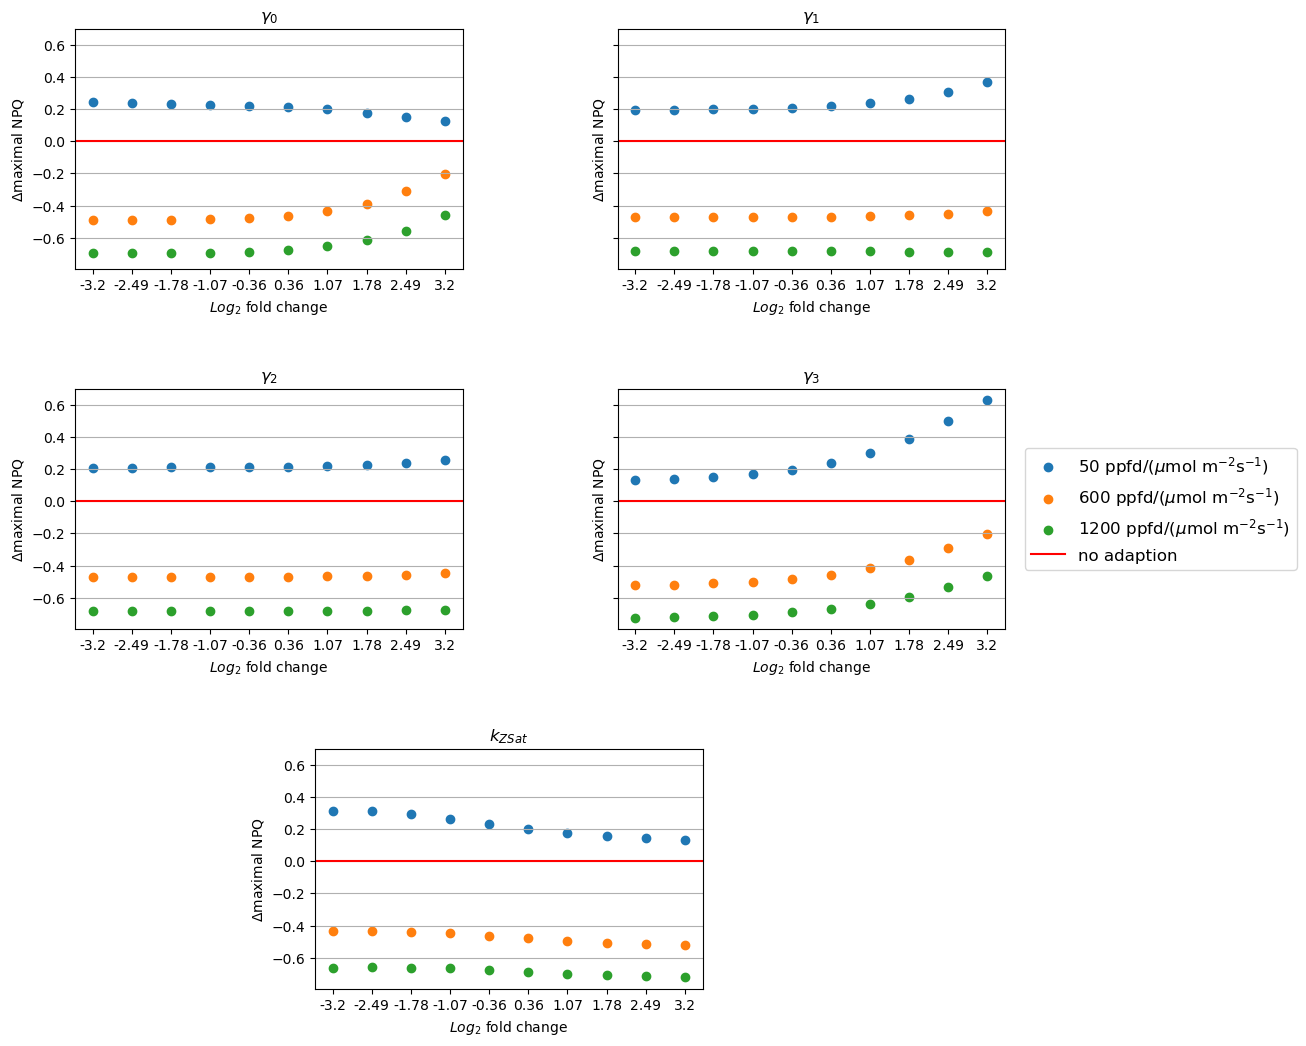

In [19]:
listis = []
for i in log2:
    listis.append(str(round(i,2)))

color = cm.rainbow(np.linspace(0, 1, 10))
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(12, 12), sharey=True)
fig.delaxes(ax6)
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.5)
box = ax5.get_position()
box.x0 = box.x0 + 0.2
box.x1 = box.x1 + 0.2
ax5.set_position(box)
#ax1.set_title("A" , loc="left", fontdict={'fontsize': 30, 'fontweight': 'heavy'})
#ax1.plot(listis,gamma0_npq, label="no adaption", )
ax1.scatter(listis, gamma0_npq_50diff, label= "50 ppfd")
ax1.scatter(listis, gamma0_npq_600diff, label= "600 ppfd")
ax1.scatter(listis, gamma0_npq_1200diff, label= "1200 ppfd")
ax1.axhline(y=0, color='r', linestyle='-')
ax1.grid(axis="y")
ax1.set(title="$\gamma_{0}$",
    xlabel="$Log_2$ fold change",
    ylabel="$\Delta$maximal NPQ",
)
ax2.scatter(listis, gamma1_npq_50diff, label= "50 ppfd")
ax2.scatter(listis, gamma1_npq_600diff, label= "600 ppfd")
ax2.scatter(listis, gamma1_npq_1200diff, label= "1200 ppfd")
ax2.axhline(y=0, color='r', linestyle='-')
ax2.grid(axis="y")
ax2.set(title="$\gamma_{1}$",
    xlabel="$Log_2$ fold change",
    ylabel="$\Delta$maximal NPQ",
)
ax3.scatter(listis, gamma2_npq_50diff, label= "50 ppfd")
ax3.scatter(listis, gamma2_npq_600diff, label= "600 ppfd")
ax3.scatter(listis, gamma2_npq_1200diff, label= "1200 ppfd")
ax3.axhline(y=0, color='r', linestyle='-')
ax3.grid(axis="y")
ax3.set(title="$\gamma_{2}$",
    xlabel="$Log_2$ fold change",
    ylabel="$\Delta$maximal NPQ",
)
ax4.scatter(listis, gamma3_npq_50diff, label= "50 ppfd")
ax4.scatter(listis, gamma3_npq_600diff, label= "600 ppfd")
ax4.scatter(listis, gamma3_npq_1200diff, label= "1200 ppfd")
ax4.axhline(y=0, color='r', linestyle='-')
ax4.grid(axis="y")
ax4.set(title="$\gamma_{3}$",
    xlabel="$Log_2$ fold change",
    ylabel="$\Delta$maximal NPQ",
)
ax5.scatter(listis, kZSat_npq_50diff, label= "50 ppfd/($\mu$mol m$^{-2}$s$^{-1}$)")
ax5.scatter(listis, kZSat_npq_600diff, label= "600 ppfd/($\mu$mol m$^{-2}$s$^{-1}$)")
ax5.scatter(listis, kZSat_npq_1200diff, label= "1200 ppfd/($\mu$mol m$^{-2}$s$^{-1}$)")
ax5.axhline(y=0, color='r', linestyle='-', label="no adaption")
ax5.grid(axis="y")
ax5.set(title="$k_{ZSat}$",
    xlabel="$Log_2$ fold change",
    ylabel="$\Delta$maximal NPQ",
)
handles, labels = ax5.get_legend_handles_labels()

plt.figlegend(handles, labels, loc ='center right',bbox_to_anchor=(0.55, 0., 0.6, 1), labelspacing=0.5,fontsize=12)

In [27]:
gamma0_npq_1200diff